## Comparing a simple KG to real-world complex networks

Using a simple example KG generated from a small text using KGen

# Environment Setup

Install & imports

In [1]:
# Install required packages
import sys
!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.8 MB/s eta 0:00:00


Auxiliary functions

In [2]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))

    Ref.: https://stackoverflow.com/a/62662992
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

# Loading our example KG, generated (by [KGen](https://github.com/rossanez/KGen)) from the following unstructured text:
```
Knowledge Graphs belong to the field of Semantic Web. They may be linked to computational ontologies.
Temporal Knowledge Graphs represent the evolution of knowledge.
```
The KG has links to concepts from the [CSO](https://cso.kmi.open.ac.uk) ontology.

In [3]:
raw_kg = RDFGraph()
raw_kg.parse(data="""
@prefix	rdfs:	<http://www.w3.org/2000/01/rdf-schema#>	.
@prefix	local:	<http://local/local.owl#>	.
@prefix	cso:	<https://cso.kmi.open.ac.uk/topics/>	.
@prefix	rdf:	<http://www.w3.org/1999/02/22-rdf-syntax-ns#>	.
@prefix	owl:	<http://www.w3.org/2002/07/owl#>	.

#### Statements ####

local:s2	a	rdf:Statement	;
	rdf:subject	local:temporal_knowledge_graph	;
	rdf:predicate	local:represent	;
	rdf:object	local:evolution_of_knowledge	;
	rdfs:label	"temporal knowledge graphs represent the evolution of knowledge"	.

local:s1	a	rdf:Statement	;
	rdf:subject	local:knowledge_graph	;
	rdf:predicate	local:link	;
	rdf:object	local:computational_ontology	;
	local:AM-MOD	local:may	;
	rdfs:label	"knowledge graphs may be linked to computational ontologies"	.

local:s0	a	rdf:Statement	;
	rdf:subject	local:knowledge_graph	;
	rdf:predicate	local:belong	;
	rdf:object	local:field_of_semantic_web	;
	rdfs:label	"knowledge graphs belong to the field of semantic web"	.


#### Classes ####

local:temporal_knowledge_graph	a	rdf:Class	;
	rdfs:label	"temporal knowledge graph"	.

local:temporal_knowledge	a	rdf:Class	;
	rdfs:label	"temporal knowledge"	.

local:knowledge	a	rdf:Class	;
	rdfs:label	"knowledge"	.

local:knowledge_graph	a	rdf:Class	;
	rdfs:label	"knowledge graph"	.

local:graph	a	rdf:Class	;
	rdfs:label	"graph"	.

local:temporal	a	rdf:Class	;
	rdfs:label	"temporal"	.

local:represent	a	rdf:Class	;
	rdfs:label	"represent"	.

local:evolution_of_knowledge	a	rdf:Class	;
	rdfs:label	"evolution of knowledge"	.

local:evolution	a	rdf:Class	;
	rdfs:label	"evolution"	.

local:link	a	rdf:Class	;
	rdfs:label	"link"	.

local:computational_ontology	a	rdf:Class	;
	rdfs:label	"computational ontologies"	.

local:ontology	a	rdf:Class	;
	rdfs:label	"ontologies"	.

local:computational	a	rdf:Class	;
	rdfs:label	"computational"	.

local:may	a	rdf:Class	;
	rdfs:label	"may"	.

local:belong	a	rdf:Class	;
	rdfs:label	"belong"	.

local:field_of_semantic_web	a	rdf:Class	;
	rdfs:label	"field of semantic web"	.

local:field	a	rdf:Class	;
	rdfs:label	"field"	.

local:semantic_web	a	rdf:Class	;
	rdfs:label	"semantic web"	.

local:web	a	rdf:Class	;
	rdfs:label	"web"	.

local:semantic	a	rdf:Class	;
	rdfs:label	"semantic"	.

#### Mapped Relations ####

cso:ontology	rdfs:label	"ontology"	.
local:ontology	owl:sameAs	cso:ontology	.
cso:semantic_web	rdfs:label	"semantic web"	.
local:semantic_web	owl:sameAs	cso:semantic_web	.

#### Relations ####

local:computational_ontology	rdfs:member	local:computational	.
local:evolution_of_knowledge	rdfs:member	local:knowledge	.
local:field_of_semantic_web	rdfs:member	local:semantic_web	.
local:temporal_knowledge_graph	rdfs:subClassOf	local:graph	.
local:temporal_knowledge	rdfs:member	local:temporal	.
local:computational_ontology	rdfs:subClassOf	local:ontology	.
local:temporal_knowledge_graph	rdfs:subClassOf	local:knowledge_graph	.
local:evolution_of_knowledge	rdfs:member	local:evolution	.
local:semantic_web	rdfs:member	local:semantic	.
local:knowledge_graph	rdfs:member	local:knowledge	.
local:temporal_knowledge_graph	rdfs:member	local:temporal_knowledge	.
local:field_of_semantic_web	rdfs:member	local:field	.
local:knowledge_graph	rdfs:subClassOf	local:graph	.
local:semantic_web	rdfs:subClassOf	local:web	.
local:temporal_knowledge	rdfs:subClassOf	local:knowledge	.
""", format='ttl') # Turtle format

print("rdflib Graph loaded successfully with {} triples".format(len(raw_kg)))

rdflib Graph loaded successfully with 75 triples


## Converting rdflib.Graph to networkx.MultiDiGraph

KGs are directed graphs with the possibility of multiple paralell edges.

In [4]:
kg = rdflib_to_networkx_multidigraph(raw_kg)

print("networkx Graph loaded successfully with length {}".format(len(kg)))

networkx Graph loaded successfully with length 51


# General Network Metrics

Network size and density

In [5]:
# Network size
print(f"NETWORK SIZE")
print("============")
print("The network has {} nodes and {} edges".format(kg.number_of_nodes(), kg.number_of_edges()))
print()

# Density
print(f"NETWORK DENSITY")
print("============")
print("The network density is {}".format(nx.density(kg)))
print()

NETWORK SIZE
The network has 51 nodes and 75 edges

NETWORK DENSITY
The network density is 0.029411764705882353



# Scale-free Networks

In-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

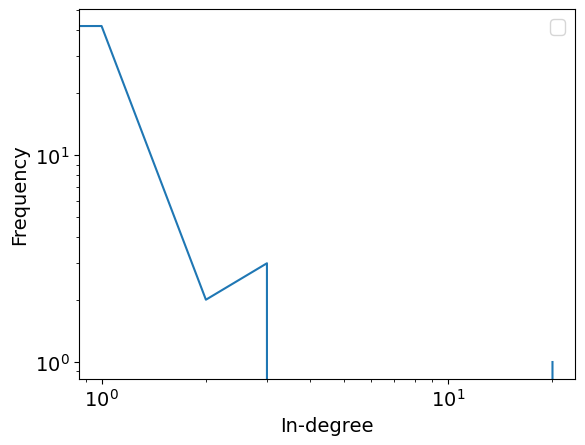

In [6]:
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

degree_freq = degree_histogram_directed(kg, in_degree=True)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq)
plt.legend(loc="upper right")
plt.xlabel('In-degree')
plt.ylabel('Frequency')

Out-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

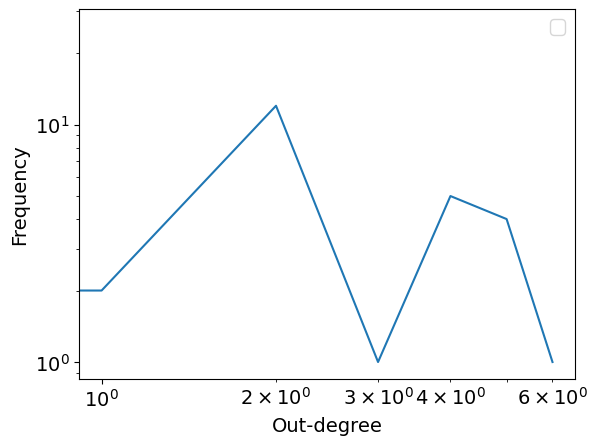

In [7]:
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))


degree_freq = degree_histogram_directed(kg, out_degree=True)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq)
plt.legend(loc="upper right")
plt.xlabel('Out-degree')
plt.ylabel('Frequency')

Are there HUBS available?

In [8]:
h, a = nx.hits(kg)

print(f"Network Hubs:")
print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
print("")
print(f"Network Authorities:")
print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
print("")

Network Hubs:
[(rdflib.term.URIRef('http://local/local.owl#knowledge_graph'), 0.059750730268886595), (rdflib.term.URIRef('http://local/local.owl#temporal_knowledge_graph'), 0.0573628914028062), (rdflib.term.URIRef('http://local/local.owl#evolution_of_knowledge'), 0.05694198130698345), (rdflib.term.URIRef('http://local/local.owl#temporal_knowledge'), 0.05694198130698345), (rdflib.term.URIRef('http://local/local.owl#semantic_web'), 0.05383510551222542), (rdflib.term.URIRef('http://local/local.owl#field_of_semantic_web'), 0.05093399515166182), (rdflib.term.URIRef('http://local/local.owl#computational_ontology'), 0.05093399515166181), (rdflib.term.URIRef('http://local/local.owl#ontology'), 0.04844003429109034), (rdflib.term.URIRef('http://local/local.owl#semantic'), 0.046178904376648955), (rdflib.term.URIRef('http://local/local.owl#may'), 0.046178904376648955), (rdflib.term.URIRef('http://local/local.owl#field'), 0.046178904376648955), (rdflib.term.URIRef('http://local/local.owl#knowledge'

# Communities

Check for communities using the Clauset-Newman-Moore Algorithm (greedy modularity - applicable to directed graphs)

In [9]:
comms = nx.community.greedy_modularity_communities(kg)

print(f'Network -- Found {len(comms)} communities.')
idx = 0
for i in comms:
    print(f'Community {idx} has {len(i)} nodes.')
    #print(i)
    idx = idx + 1

Network -- Found 6 communities.
Community 0 has 11 nodes.
Community 1 has 10 nodes.
Community 2 has 9 nodes.
Community 3 has 8 nodes.
Community 4 has 7 nodes.
Community 5 has 6 nodes.


# Small-world networks

Does it have a low average shortest path?

In [10]:
if nx.is_strongly_connected(kg):
    print(f'Network -- Average shortest path length: {nx.average_shortest_path_length(kg)}')
else:
    print(f'Network is NOT strongly connected!')

Network is NOT strongly connected!


Does it have a high clustering coefficient?

In [11]:
# create weighted graph from M, as method is not implemented for MultiDiGraphs
DG = nx.DiGraph()
for u,v in kg.edges():
    if DG.has_edge(u,v):
        DG[u][v]['weight'] += 1
    else:
        DG.add_edge(u, v, weight=1)

ccs = nx.clustering(DG,weight='weight').values()

print(f"Network -- Clustering coefficient: {sum(ccs)/len(ccs)}")

Network -- Clustering coefficient: 0.06538650547938472


# Some Centrality Measurements

NW DEGREE CENTRALITY
The mean degree centrality is 0.05882352941176474, with stdev 0.06045319044760266
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.4
The minimum node is knowledge graph, with value 0.02
(0.4, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02) (1, 1, 3, 7, 2, 11, 3, 23)


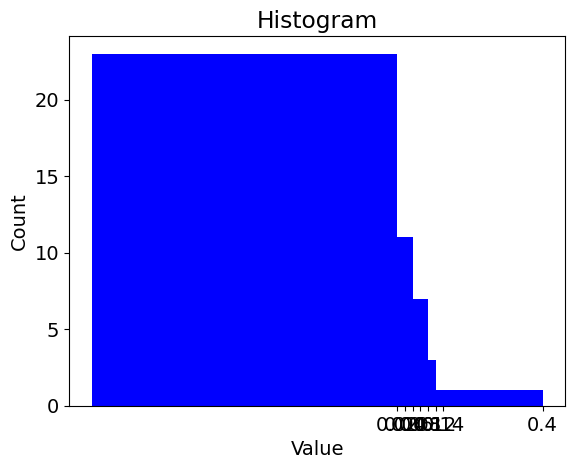


NW PAGERANK
The mean network pagerank is 0.0196078431372549, with stdev 0.015356888824715616
The maximum node is http://www.w3.org/1999/02/22-rdf-syntax-ns#Class, with value 0.12461727430772873
The minimum node is http://local/local.owl#s2, with value 0.0129561392923949
(0.12461727430772873, 0.029056969901307857, 0.027846265503664844, 0.023637078864826647, 0.023002045524630813, 0.02132559550541383, 0.01986541192517872, 0.019831717269953992, 0.019798534239265482, 0.019691935469420906, 0.019631439001339557, 0.01957132650133407, 0.01939864616198377, 0.01924266421275766, 0.01919696982319141, 0.017517735923641954, 0.017114932721585357, 0.01625703200084176, 0.016177392727189335, 0.016099401752576282, 0.01570637048341854, 0.015533142040230447, 0.015158785362087786, 0.014791677683805638, 0.0129561392923949) (1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 5, 3, 3, 2, 7, 4, 3)


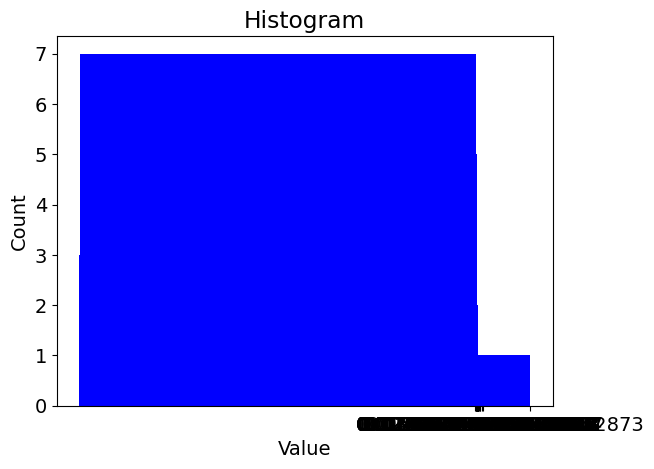


NW BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.0008483393357342937, with stdev 0.0014101076287557543
The maximum node is http://local/local.owl#knowledge_graph, with value 0.005544217687074831
The minimum node is knowledge graph, with value 0.0
(0.005544217687074831, 0.004897959183673469, 0.0042176870748299325, 0.00380952380952381, 0.0029591836734693877, 0.002857142857142857, 0.0024489795918367346, 0.0021768707482993197, 0.0020408163265306124, 0.0012244897959183673, 0.0008163265306122449, 0.0005442176870748299, 0.0005102040816326531, 0.0) (1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 3, 2, 2, 30)


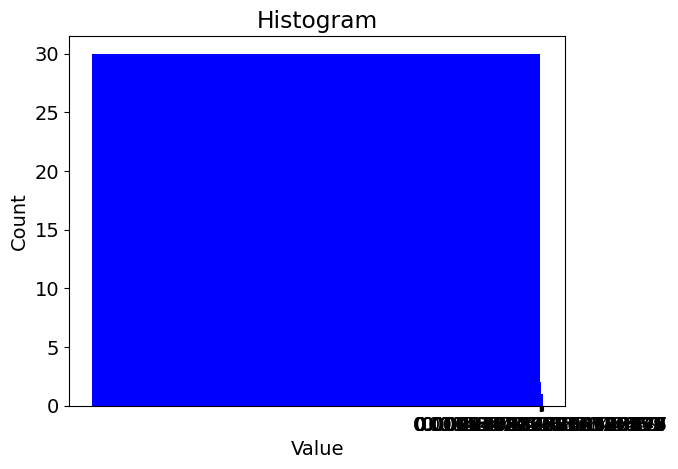

In [12]:
# Degree centrality -- mean and stdev
dc = nx.degree_centrality(kg)
degrees = []
for k,v in dc.items():
    degrees.append(v)

print(f"NW DEGREE CENTRALITY")
print("=================")
print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
histogram(dc)
print()

# PageRank -- mean and stdev
pc = nx.pagerank(kg)
degrees = []
for k,v in pc.items():
    degrees.append(v)

print(f"NW PAGERANK")
print("======================")
print("The mean network pagerank is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(pc, key=pc.get), max(pc.values())))
print("The minimum node is {}, with value {}".format(min(pc, key=pc.get), min(pc.values())))
histogram(pc)
print()


# Betweenness centrality -- mean and stdev
bc = nx.betweenness_centrality(kg)
degrees = []
for k,v in bc.items():
    degrees.append(v)

print(f"NW BETWEENNESS CENTRALITY")
print("======================")
print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
histogram(bc)
print()